# COMPUTER VISION LAB 5

## GROUP MEMBERS:

Sani Abdullahi Sani - 2770930

Christine Mataranyika - 2770653

Samuel Mba - 2927208

In [ ]:
!pip install cachier

In [ ]:
from natsort import natsorted
import os
import re
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx

import sklearn.neighbors

import imageio
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
# caching with sane defaults
from cachier import cachier
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')

In [ ]:
# Mount gdrive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
############################## Stuff for loading and rescaling the puzzle pieces nicely ################################
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'/content/drive/MyDrive/CV Lab 5/puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'/content/drive/MyDrive/CV Lab 5/puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array([img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array([img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])

assert DATA_IMGS.shape == (48, SIZE[0], SIZE[1], 3)
assert DATA_MSKS.shape == (48, SIZE[0], SIZE[1])

with open(f'/content/drive/MyDrive/CV Lab 5/puzzle_corners_{SIZE[1]}x{SIZE[0]}/corners.json', mode='r') as f:
    DATA_CORNER_NAMES, DATA_CORNERS = json.load(f)
    DATA_CORNERS = np.array(DATA_CORNERS)

assert len(DATA_CORNER_NAMES) == len(DATA_CORNERS) == len(DATA_IMGS) == len(DATA_MSKS) == len(DATA_PATH_PAIRS)

SCALE = 0.25

MATCH_IMGS = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(DATA_IMGS, 'Resizing Images')]
MATCH_MSKS = [cv2.resize(img, None, fx=SCALE, fy=SCALE) for img in tqdm(DATA_MSKS, 'Resizing Masks')]
MATCH_CORNERS = DATA_CORNERS

print('\n', DATA_IMGS[0].shape, '->', MATCH_IMGS[0].shape)

Loading Images:   0%|          | 0/48 [00:00<?, ?it/s]<ipython-input-80-551a322ebd07>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DATA_IMGS = np.array([img_as_float32(imageio.imread(img_path)) for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
Loading Masks:   0%|          | 0/48 [00:00<?, ?it/s]<ipython-input-80-551a322ebd07>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DATA_MSKS = np.array([img_as_float32(imageio.imread(msk_path)) for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])
Resizing Masks: 100%|██████████| 48/48 [00:00<00:00, 3573.87it/s]


 (768, 1024, 3) -> (192, 256, 3)


In [ ]:
################################################ Define our three classes #############################################

class Edge:
    def __init__(self, point1, point2, contour, parent_piece):
        self.parent_piece = parent_piece  # Puzzle piece the edge belongs to
        # first and last points
        self.point1 = point1  # Points should be anti-clockwise
        self.point2 = point2
        self.connected_edge = None
        self.is_flat = None

    def info(self):
        print("Point 1: ", self.point1)
        print("Point 2: ", self.point2)


class Piece:
    def __init__(self, image, idx):
        self.piece_type = None
        self.inserted = False
        # Keep track of where the pieces corner's are. Used to construct the edge variables
        self.corners = None  # randomly ordered corners
        self.top_left = None
        self.top_right = None
        self.bottom_left = None
        self.bottom_right = None
        # Edges are anti-clockwise
        self.top_edge = None
        self.left_edge = None
        self.bottom_edge = None
        self.right_edge = None
        # Edge list used for BFS generator and in inserting function to search for the necessary edge
        self.edge_list = None
        # We hold the actual image of the piece so we can insert it onto the canvas
        self.image = image
        self.idx = idx
        # We also hold the mask and transform it with the image so we always know where our piece is in the image
        self.mask = None
        # Holds image after mapping
        self.dst = None
        # ~=~=~=~=~=~=~=~=~=~=~=~=~=~ #
        self.extract_features()
        self.classify_pixels()
        self.find_corners()
        self.find_edges()

    def return_edge(self):  # generator which can be used to loop through edges in the BFS
        while True:
            for edge in self.edge_list:
                yield(edge)

    def display_im(self):  # Displays puzzle piece image
        plt.imshow(self.image)
        plt.show()
        plt.close()

    def print_corners(self):  # Prints the coordinates of the puzzle piece's corners
        print("Top left: ", self.top_left)
        print("top right: ", self.top_right)
        print("bottom right: ", self.bottom_right)
        print("bottom left: ", self.bottom_left)

    def print_edges(self):  # Prints the information of the puzzle piece's edges
        print("Top Edge")
        self.top_edge.info()
        print("Left Edge")
        self.left_edge.info()
        print("Bottom Edge")
        self.bottom_edge.info()
        print("Right Edge")
        self.right_edge.info()

    def flipPoints(self,point, transform):
        flipped_point = np.array([point[1],point[0]])
        flipped_point=np.append(flipped_point,1)
        return (np.dot(flipped_point, transform.transpose()))

    def update_edges(self, transform):
        # TODO: Update the corner and edge information of the puzzle piece

        print(transform)

        # Update the corners by flipping their coordinates
        # Top Left Corner
        flipped_point = np.array([self.top_left[1],self.top_left[0]])
        flipped_point=np.append(flipped_point,1)
        self.top_left=(np.dot(flipped_point, transform.transpose()))

        # Top Right Corner
        flipped_point = np.array([self.top_right[1],self.top_right[0]])
        flipped_point=np.append(flipped_point,1)
        self.top_right=(np.dot(flipped_point, transform.transpose()))

        # Bottom Left Corner
        flipped_point = np.array([self.bottom_left[1],self.bottom_left[0]])
        flipped_point=np.append(flipped_point,1)
        self.bottom_left=(np.dot(flipped_point, transform.transpose()))

        # Bottom Right Corner
        flipped_point = np.array([self.bottom_right[1],self.bottom_right[0]])
        flipped_point=np.append(flipped_point,1)
        self.bottom_right=(np.dot(flipped_point, transform.transpose()))

        # Update edges by flipping their points

        # Top Edge
        point1 = self.top_edge.point1
        point2 = self.top_edge.point2

        self.top_edge.point1=self.flipPoints(point1,transform)
        self.top_edge.point2=self.flipPoints(point2,transform)

        # Right Edge
        point1 = self.right_edge.point1
        point2 = self.right_edge.point2

        self.right_edge.point1=self.flipPoints(point1,transform)
        self.right_edge.point2=self.flipPoints(point2,transform)

        # Left Edge
        point1 = self.left_edge.point1
        point2 = self.left_edge.point2

        self.left_edge.point1=self.flipPoints(point1,transform)
        self.left_edge.point2=self.flipPoints(point2,transform)

        # Bottom Edge
        point1 = self.bottom_edge.point1
        point2 = self.bottom_edge.point2

        self.bottom_edge.point1=self.flipPoints(point1,transform)
        self.bottom_edge.point2=self.flipPoints(point2,transform)

        return

    def extract_features(self):
        # Function which will extract all the necessary features to classify pixels
        # into background and foreground
        # Should take no input and use self.image. Returns the features image (Not for Lab 7)
        return

    def classify_pixels(self):
        # Uses the feature image from self.extract_features to classify pixels
        # into foreground and background pixels. Returns the inferred mask
        # and should update self.mask with this update as we need it in future (Not for Lab 7)
        self.mask = MATCH_MSKS[self.idx]

    def find_corners(self):
        # Finds the corners of the puzzle piece (should use self.mask). Needs to update
        # the corner info of the object (eg: self.top_left). (Not for Lab 7)
        corners = MATCH_CORNERS[self.idx] * self.mask.shape[::-1]

        # sort in anti-clockwise direction
        angle_around_center = np.arctan2(*(corners - corners.mean(axis=0)).T)
        self.corners = corners[np.argsort(angle_around_center), :]

        self.top_left = self.corners[0][::-1]
        self.top_right = self.corners[3][::-1]
        self.bottom_right = self.corners[2][::-1]
        self.bottom_left = self.corners[1][::-1]

    def find_edges(self):
        # Finds the contour information from self.mask. Should then create the
        # edge objects for this piece. Also needs to update self.edge_list
        # (ending in None) and self.piece_type based on number of non-straight edges (not for Lab 7)
        self.top_edge = Edge(self.top_right, self.top_left, None, self)  # [0][0], [0][-1]
        self.left_edge = Edge(self.top_left, self.bottom_left, None, self)  # 1
        self.bottom_edge = Edge(self.bottom_left, self.bottom_right, None, self)  # 2
        self.right_edge = Edge(self.bottom_right, self.top_right, None, self)  # 3
        self.edge_list = [self.top_edge, self.left_edge, self.bottom_edge, self.right_edge, None]

    def insert(self):  # Inserts the piece into the canvas using an affine transformation
        # TODO: Implement this function
        print("Inserting piece: ", self.idx)

################################################ Question 1 #############################################

        counter = 0
        for edge in self.edge_list:
             # Check for None values in edge list
            if (edge is not None):

                if (edge.connected_edge is not None):

                    if (edge.connected_edge.parent_piece.inserted == True):
                        counter += 1
        # Determine piece type based on the number of connected edges
        if (counter == 0):
            self.piece_type = 'corner'
        elif (counter == 1):
            self.piece_type = 'edge'
        elif (counter == 2):
            self.piece_type = 'interior'
        else:
            raise Exception("Number of occurrences > 2!")

################################################ Question 2 #############################################

        pts_src = []
        pts_dst = []

        if (self.piece_type == 'corner'):

            #Initialise 2 edges
            first_edge = None
            second_edge = None

            count = 0 # Tracks the number of detected flat edges.

            # Loop through edge list to find 2 flat edges
            for edge in self.edge_list:
                if (edge is not None):
                    if edge.is_flat == True:
                        count +=1
                        if count == 1:
                            first_edge = edge
                        else:
                            second_edge = edge
                            break

            assert((first_edge.point2 == second_edge.point1).all())

            # map first edge pt2 to pts src
            pts_src.append([first_edge.point2[1],first_edge.point2[0]])
            pts_dst.append([0,800])

            # map first edge point1 to lie on left edge of canvas
            pts_src.append([first_edge.point1[1],first_edge.point1[0]])

            dist_x=np.abs(first_edge.point1[0]-first_edge.point2[0])
            dist_y=np.abs(first_edge.point1[1]-first_edge.point2[1])

            pts_dst.append([0+dist_y,800-dist_x])

            pts_src.append([second_edge.point2[1],second_edge.point2[0]])

            # preserve the distance: we look at distance of point1 to point2
            dist_x=np.abs(second_edge.point2[0]-second_edge.point1[0])
            dist_y=np.abs(second_edge.point2[1]-second_edge.point1[1])
            pts_dst.append([0+dist_y,800-dist_x])

            # Use mapping to get matrix m
            M = cv2.getAffineTransform(np.float32(pts_src), np.float32(pts_dst))

            self.dst = cv2.warpAffine(self.image, np.float64(M), (700,800) )

            self.mask = cv2.warpAffine(self.mask, np.float64(M), (700,800) )

            # call self.update edges
            self.update_edges(M)

            # blend puzzle piece pixels onto canvas
            for channel in range(3):
                canvas[:,:,channel]=self.mask*self.dst[:,:,channel] + (1-self.mask)*canvas[:,:,channel]

################################################ Question 4 #############################################

        elif (self.piece_type == 'interior'):
            for edge in self.edge_list:
                if (edge is not None):
                    if (edge.connected_edge is not None and edge.connected_edge.parent_piece.inserted == True):

                        pt1=[edge.point1[1], edge.point1[0]]
                        if (pt1 not in pts_src):
                            # append edge.point1 to points src
                            pts_src.append(pt1)

                            # append edge.connected_edge.pt2 to points dst
                            pt2=[edge.connected_edge.point2[0],edge.connected_edge.point2[1]]
                            pts_dst.append(pt2)

                        # checking edge.point2
                        pt2=[edge.point2[1], edge.point2[0]]
                        if (pt2 not in pts_src):
                            # append edge.point2 to points src
                            pts_src.append(pt2)

                            # append edge.connected_edge.pt1 to points dst
                            pt1=[edge.connected_edge.point1[0],edge.connected_edge.point1[1]]
                            pts_dst.append(pt1)

            M = cv2.getAffineTransform(np.float32(pts_src), np.float32(pts_dst))

            self.dst = cv2.warpAffine(self.image, np.float64(M), (700,800) )
            self.mask = cv2.warpAffine(self.mask, np.float64(M), (700,800) )

            # call self.update edges
            self.update_edges(M)

            for channel in range(3):
                canvas[:,:,channel]=self.mask*self.dst[:,:,channel] + (1-self.mask)*canvas[:,:,channel]

################################################ Question 5 #############################################

        elif (self.piece_type == 'edge'):
            print('edges')
            print(self.edge_list[0].point1,self.edge_list[0].point2)
            print(self.edge_list[1].point1,self.edge_list[1].point2)
            print(self.edge_list[2].point1,self.edge_list[2].point2)
            print(self.edge_list[3].point1,self.edge_list[3].point2)

            for edge in self.edge_list:
                if(edge is not None):
                    if (edge.connected_edge is not None and edge.connected_edge.parent_piece.inserted == True):

                        third_edge=edge
                        pts_src = [ [third_edge.point1[1],third_edge.point1[0]],[third_edge.point2[1],third_edge.point2[0]]]
                        pts_dst = [[third_edge.connected_edge.point2[0],third_edge.connected_edge.point2[1]],[third_edge.connected_edge.point1[0],third_edge.connected_edge.point1[1]]]
                        print('third edge', pts_dst)
                        print('third edge', pts_src)

                        orig_norm=np.linalg.norm([third_edge.point2[1]-third_edge.point1[1], third_edge.point2[0]-third_edge.point1[0]])

                        canvas_norm=np.linalg.norm([third_edge.connected_edge.point2[0]-third_edge.connected_edge.point1[0],third_edge.connected_edge.point2[1]-third_edge.connected_edge.point1[1]])

                        # Calculate scaling factor
                        print('norms',orig_norm, canvas_norm)
                        ratio = orig_norm/canvas_norm
                        print('ratio:', ratio)

                        if(pts_dst[0][0]-pts_dst[1][0] > (pts_dst[0][1]-pts_dst[1][1])):

                            fourth_edge = None
                            counter=0
                            blnTemp = False
                            for edge in self.edge_list:

                                # Find next anti-clockwise edge
                                if blnTemp==True:
                                    fourth_edge = edge
                                    break

                                if edge == third_edge:
                                    # counter
                                    blnTemp = True
                                    # break
                                counter+=1

                            if (fourth_edge is None):
                                fourth_edge=self.edge_list[0]

                            # Appends the second point of the fourth edge to the source points list
                            pts_src.append([fourth_edge.point2[1],fourth_edge.point2[0]])

                            # Calculates the length of the edge using the Euclidean norm
                            edge_norm = np.linalg.norm([fourth_edge.point2[1]-fourth_edge.point1[1],fourth_edge.point2[0]-fourth_edge.point1[0]])

                            # Computes the destination point based on the edge length and scaling ratio
                            pts_dst.append([pts_dst[1][0]+int(ratio*edge_norm),pts_dst[1][1]])

                            # Get the affine transformation matrix from source points to destination points
                            M = cv2.getAffineTransform(np.float32(pts_src), np.float32(pts_dst))

                            self.dst = cv2.warpAffine(self.image, np.float64(M), (700,800) )

                            self.mask = cv2.warpAffine(self.mask, np.float64(M), (700,800) )

                            # Updates the edge information based on the transformation matrix
                            self.update_edges(M)

                            for channel in range(3):
                                canvas[:,:,channel]=self.mask*self.dst[:,:,channel] + (1-self.mask)*canvas[:,:,channel]

                        else:
                            fifth_edge = None

                            fifth_edge=self.edge_list[-2]
                            counter=0
                            for edge in self.edge_list:

                                # Find next anti-clockwise edge
                                if edge==third_edge:
                                    break

                                if (self.edge_list[counter-1] is None):
                                    fifth_edge=self.edge_list[counter-2]
                                else:
                                    fifth_edge=self.edge_list[counter-1]
                                counter+=1

                            print('Fifth edge 2',fifth_edge.point1, fifth_edge.point2)
                            print('pts src',pts_src)

                            pts_src.append([fifth_edge.point1[1],fifth_edge.point1[0]])

                            edge_norm = np.linalg.norm([fifth_edge.point2[1]-fifth_edge.point1[1],fifth_edge.point2[0]-fifth_edge.point1[0]])

                            if (self.idx==44):

                                pts_dst.append([ pts_dst[0][0],pts_dst[0][1]-int(ratio*edge_norm)])
                            else:
                                pts_dst.append([ pts_dst[1][0],pts_dst[1][1]-int(ratio*edge_norm)])

                            print('fifth edge src',pts_src)
                            print('fifth edge dst',pts_dst)

                            M = cv2.getAffineTransform(np.float32(pts_src), np.float32(pts_dst))
                            print('M', M)

                            self.dst = cv2.warpAffine(self.image, np.float64(M), (700,800) )
                            self.mask = cv2.warpAffine(self.mask, np.float64(M), (700,800) )

                            # Updates the edge information based on the transformation matrix
                            self.update_edges(M)

                            for channel in range(3):
                                canvas[:,:,channel]=self.mask*self.dst[:,:,channel] + (1-self.mask)*canvas[:,:,channel]

        return cv2.cvtColor(np.array(canvas*255).astype('uint8'), cv2.COLOR_RGB2BGR)

In [ ]:
class Puzzle(object):
    def __init__(self, imgs):
        # generate all piece information
        self.pieces = [
            Piece(img, idx)
            for idx, img in tqdm(enumerate(imgs), 'Generating Pieces')
        ]
        self._fill_connections()

    def _fill_connections(self):
        connections = np.ones((48,4,2))*-1
        connections[0,2] = [26,1]
        connections[0,3] = [5,3]
        connections[1,0] = [14,3]
        connections[1,2] = [29,3]
        connections[1,3] = [22,2]
        connections[2,0] = [19,0]
        connections[2,1] = [12,1]
        connections[2,2] = [7,2]
        connections[2,3] = [16,0]
        connections[3,0] = [44,0]
        connections[3,3] = [6,1]
        connections[4,1] = [5,1]
        connections[4,2] = [41,0]
        connections[4,3] = [34,1]
        connections[5,0] = [7,0]
        connections[5,1] = [4,1]
        connections[5,3] = [0,3]
        connections[6,0] = [37,0]
        connections[6,1] = [3,3]
        connections[6,3] = [32,1]
        connections[7,0] = [5,0]
        connections[7,1] = [26,0]
        connections[7,2] = [2,2]
        connections[7,3] = [41,1]
        connections[8,0] = [15,0]
        connections[8,1] = [46,1]
        connections[9,0] = [25,2]
        connections[9,1] = [47,2]
        connections[9,2] = [28,0]
        connections[9,3] = [12,3]
        connections[10,0] = [33,2]
        connections[10,2] = [31,0]
        connections[10,3] = [11,1]
        connections[11,0] = [19,2]
        connections[11,1] = [10,3]
        connections[11,2] = [23,1]
        connections[11,3] = [36,3]
        connections[12,0] = [41,2]
        connections[12,1] = [2,1]
        connections[12,2] = [35,1]
        connections[12,3] = [9,3]
        connections[13,0] = [27,1]
        connections[13,1] = [22,0]
        connections[13,2] = [25,0]
        connections[13,3] = [36,1]
        connections[14,0] = [30,1]
        connections[14,1] = [15,2]
        connections[14,3] = [1,0]
        connections[15,0] = [8,0]
        connections[15,2] = [14,1]
        connections[15,3] = [40,3]
        connections[16,0] = [2,3]
        connections[16,1] = [26,3]
        connections[16,3] = [33,0]
        connections[17,0] = [43,2]
        connections[17,1] = [37,1]
        connections[17,2] = [32,0]
        connections[17,3] = [20,3]
        connections[18,1] = [34,3]
        connections[18,2] = [38,2]
        connections[18,3] = [21,1]
        connections[19,0] = [2,0]
        connections[19,1] = [33,3]
        connections[19,2] = [11,0]
        connections[19,3] = [35,2]
        connections[20,0] = [39,0]
        connections[20,1] = [40,1]
        connections[20,2] = [27,3]
        connections[20,3] = [17,3]
        connections[21,1] = [18,3]
        connections[21,2] = [24,1]
        connections[22,0] = [13,1]
        connections[22,1] = [30,2]
        connections[22,2] = [1,3]
        connections[22,3] = [45,0]
        connections[23,0] = [43,1]
        connections[23,1] = [11,2]
        connections[23,2] = [31,3]
        connections[23,3] = [37,2]
        connections[24,1] = [21,2]
        connections[24,2] = [38,1]
        connections[24,3] = [42,1]
        connections[25,0] = [13,2]
        connections[25,1] = [45,3]
        connections[25,2] = [9,0]
        connections[25,3] = [35,0]
        connections[26,0] = [7,1]
        connections[26,1] = [0,2]
        connections[26,3] = [16,1]
        connections[27,0] = [30,3]
        connections[27,1] = [13,0]
        connections[27,2] = [43,3]
        connections[27,3] = [20,2]
        connections[28,0] = [9,2]
        connections[28,1] = [38,3]
        connections[28,2] = [34,2]
        connections[28,3] = [41,3]
        connections[29,1] = [42,3]
        connections[29,2] = [45,1]
        connections[29,3] = [1,2]
        connections[30,0] = [40,0]
        connections[30,1] = [14,0]
        connections[30,2] = [22,1]
        connections[30,3] = [27,0]
        connections[31,0] = [10,2]
        connections[31,2] = [44,2]
        connections[31,3] = [23,2]
        connections[32,0] = [17,2]
        connections[32,1] = [6,3]
        connections[32,3] = [39,1]
        connections[33,0] = [16,3]
        connections[33,2] = [10,0]
        connections[33,3] = [19,1]
        connections[34,1] = [4,3]
        connections[34,2] = [28,2]
        connections[34,3] = [18,1]
        connections[35,0] = [25,3]
        connections[35,1] = [12,2]
        connections[35,2] = [19,3]
        connections[35,3] = [36,2]
        connections[36,0] = [43,0]
        connections[36,1] = [13,3]
        connections[36,2] = [35,3]
        connections[36,3] = [11,3]
        connections[37,0] = [6,0]
        connections[37,1] = [17,1]
        connections[37,2] = [23,3]
        connections[37,3] = [44,1]
        connections[38,0] = [47,1]
        connections[38,1] = [24,2]
        connections[38,2] = [18,2]
        connections[38,3] = [28,1]
        connections[39,0] = [20,0]
        connections[39,1] = [32,3]
        connections[39,3] = [46,3]
        connections[40,0] = [30,0]
        connections[40,1] = [20,1]
        connections[40,2] = [46,2]
        connections[40,3] = [15,3]
        connections[41,0] = [4,2]
        connections[41,1] = [7,3]
        connections[41,2] = [12,0]
        connections[41,3] = [28,3]
        connections[42,1] = [24,3]
        connections[42,2] = [47,0]
        connections[42,3] = [29,1]
        connections[43,0] = [36,0]
        connections[43,1] = [23,0]
        connections[43,2] = [17,0]
        connections[43,3] = [27,2]
        connections[44,0] = [3,0]
        connections[44,1] = [37,3]
        connections[44,2] = [31,2]
        connections[45,0] = [22,3]
        connections[45,1] = [29,2]
        connections[45,2] = [47,3]
        connections[45,3] = [25,1]
        connections[46,1] = [8,1]
        connections[46,2] = [40,2]
        connections[46,3] = [39,3]
        connections[47,0] = [42,2]
        connections[47,1] = [38,0]
        connections[47,2] = [9,1]
        connections[47,3] = [45,2]
        connections = connections.astype(np.int16)
        for i in range(connections.shape[0]):
            for j in range(connections.shape[1]):
                if not list(connections[i,j]) == [-1,-1]:
                    self.pieces[i].edge_list[j].connected_edge=self.pieces[connections[i,j][0]].edge_list[connections[i,j][1]]
                else:
                    self.pieces[i].edge_list[j].is_flat = True

# Create our canvas with the necessary size
canvas = np.zeros((800,700,3))

Generating Pieces: 48it [00:00, 10151.60it/s]


Inserting piece:  3
[[ 1.00000000e+00  0.00000000e+00 -4.47146683e+01]
 [-3.43456122e-02  9.99531006e-01  6.62801563e+02]]
Inserting piece:  44
edges
[ 56.95204353 179.19999695] [62.40852356 60.07466507]
[62.40852356 60.07466507] [164.03552628  64.51200104]
[164.03552628  64.51200104] [158.57904053 184.66133118]
[158.57904053 184.66133118] [ 56.95204353 179.19999695]
third edge [[1.3653335571288991, 700.0781259532271], [119.80799102783203, 695.3284009673844]]
third edge [[179.1999969482422, 56.952043533325195], [60.07466506958008, 62.40852355957031]]
norms 119.25023215691533 118.53785469698465
ratio: 1.0060097043408767
Fifth edge 2 [158.57904053 184.66133118] [ 56.95204353 179.19999695]
pts src [[179.1999969482422, 56.952043533325195], [60.07466506958008, 62.40852355957031]]
fifth edge src [[179.1999969482422, 56.952043533325195], [60.07466506958008, 62.40852355957031], [184.6613311767578, 158.57904052734375]]
fifth edge dst [[1.3653335571288991, 700.0781259532271], [119.80799102783203

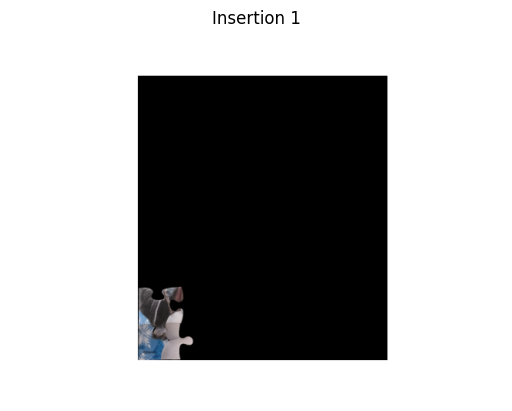

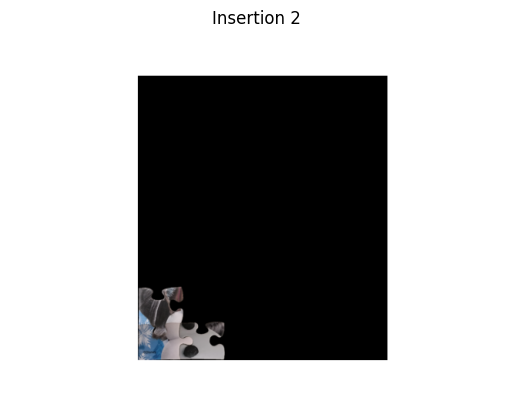

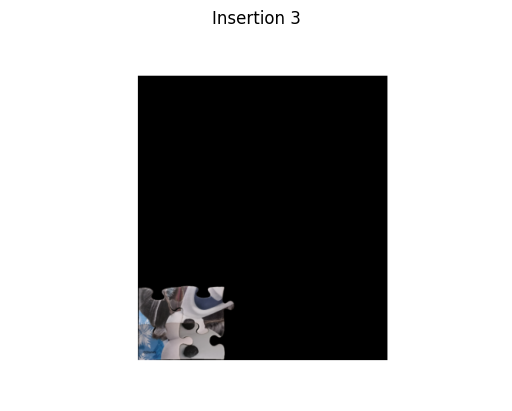

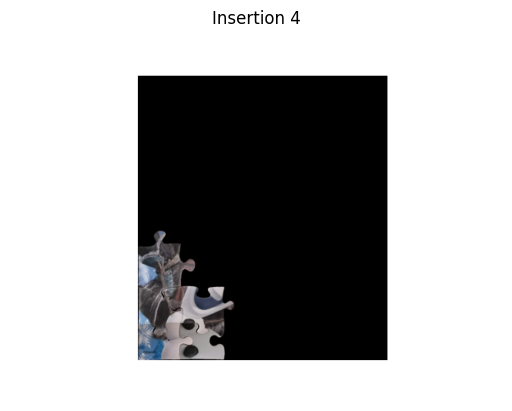

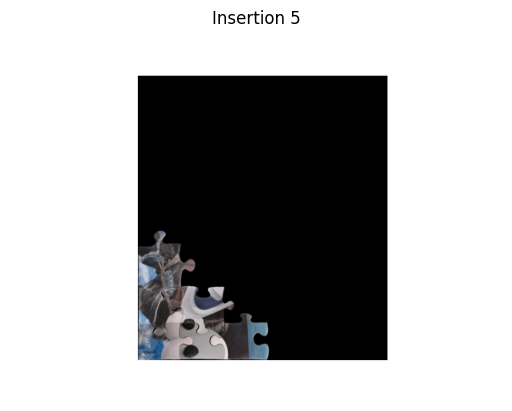

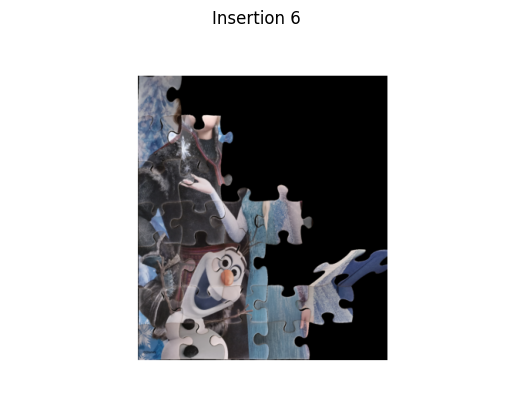

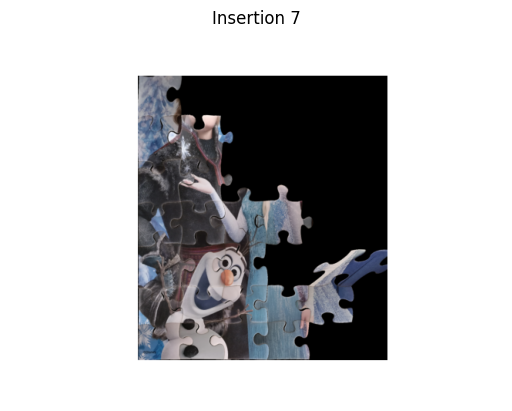

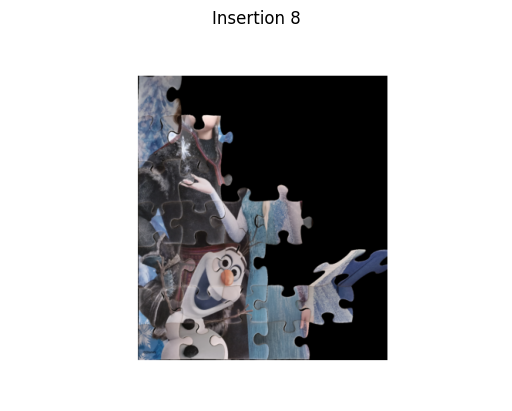

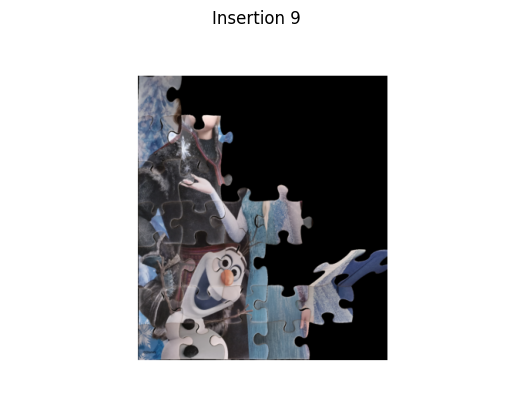

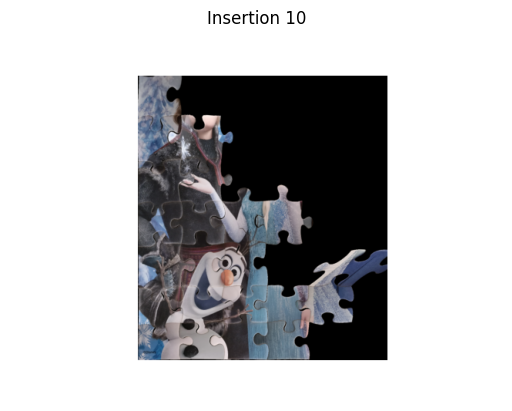

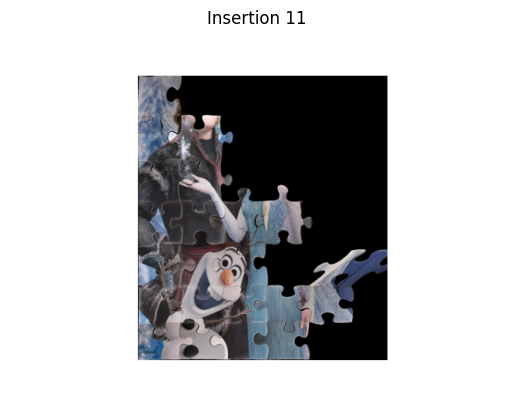

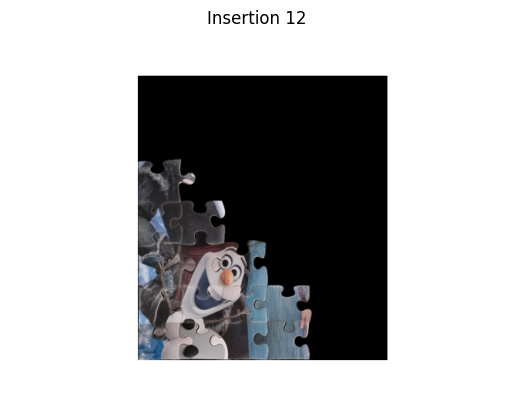

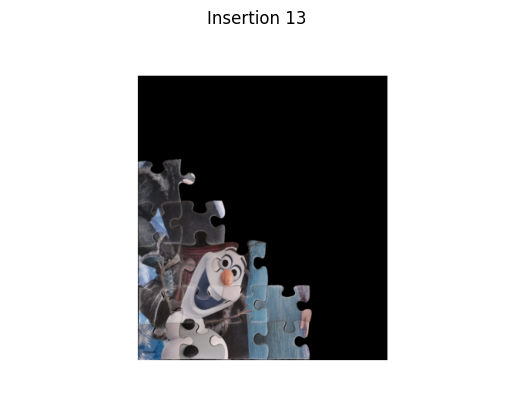

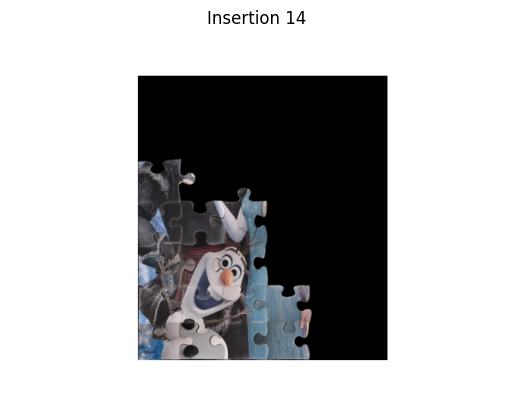

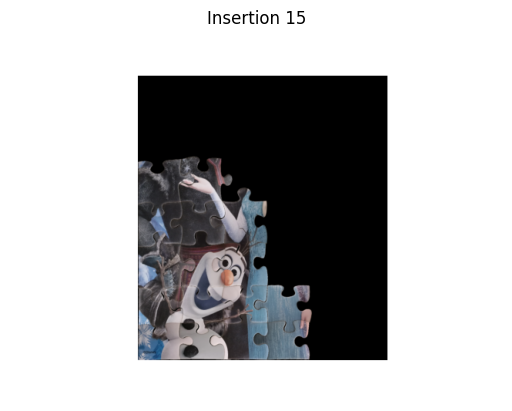

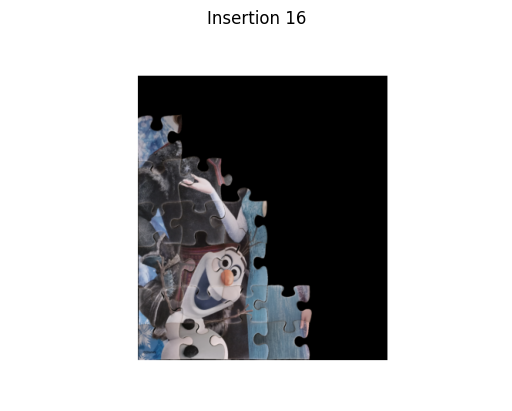

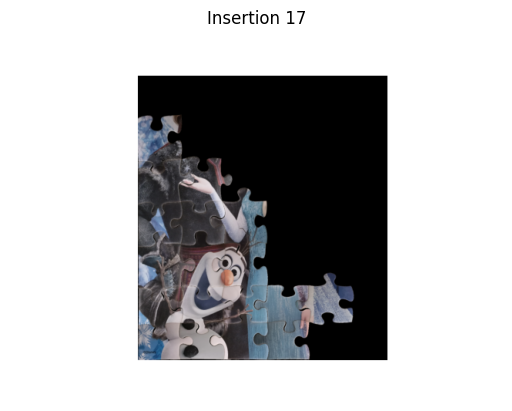

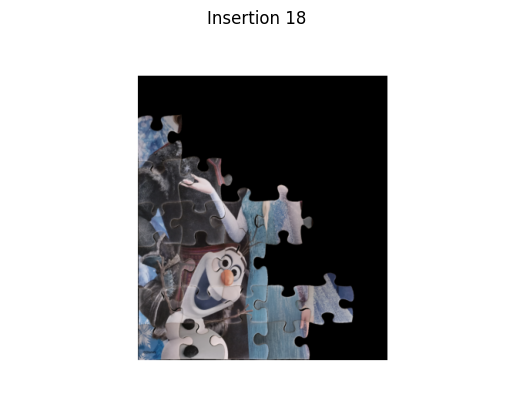

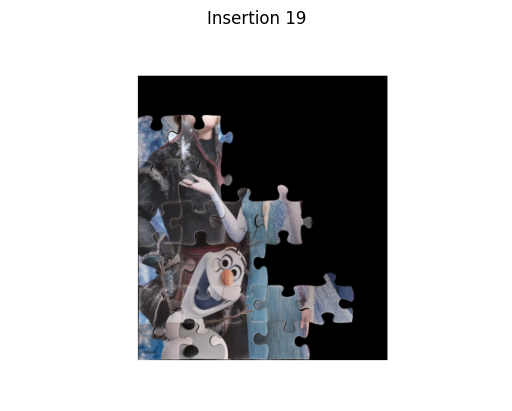

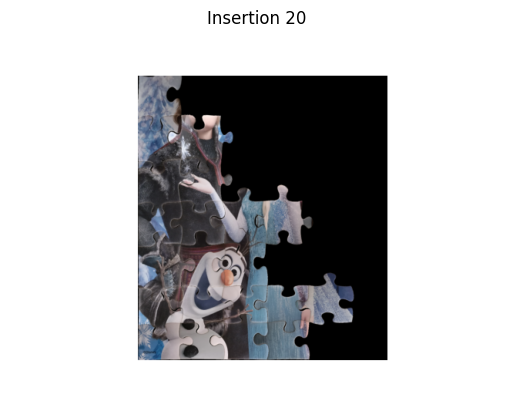

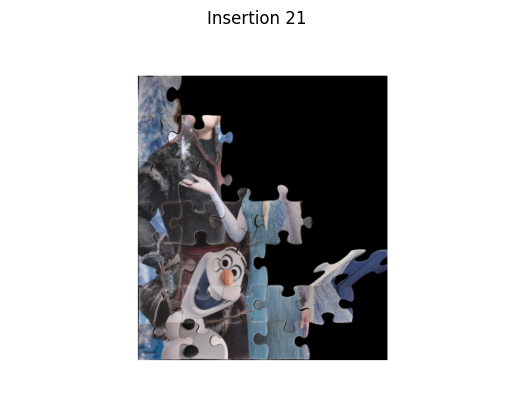

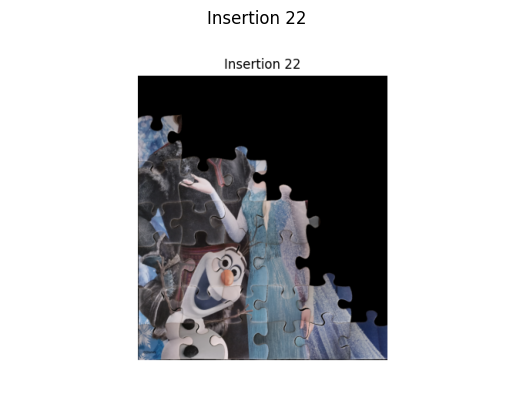

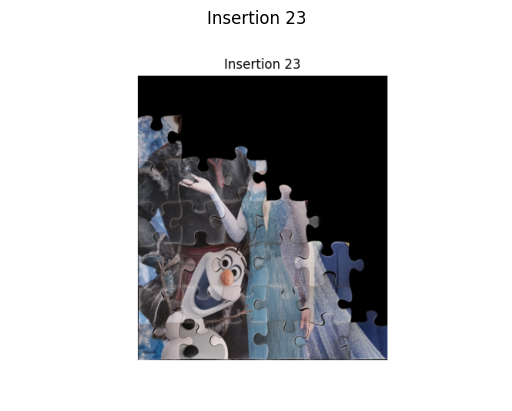

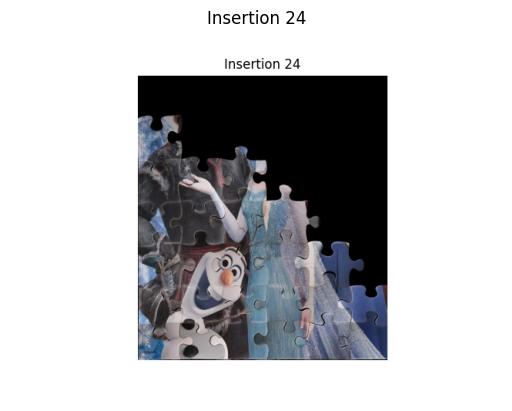

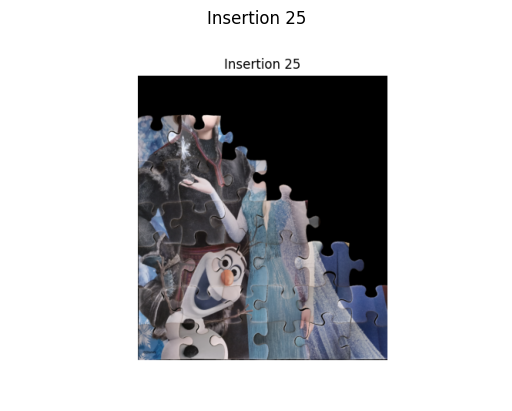

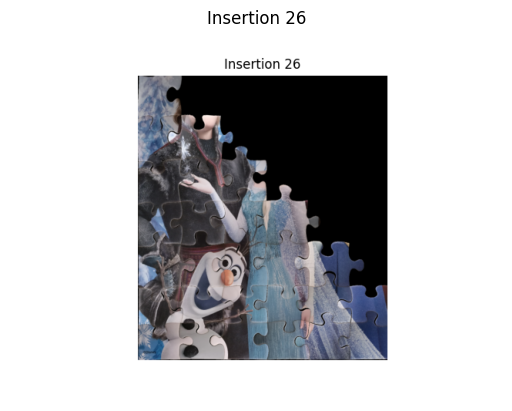

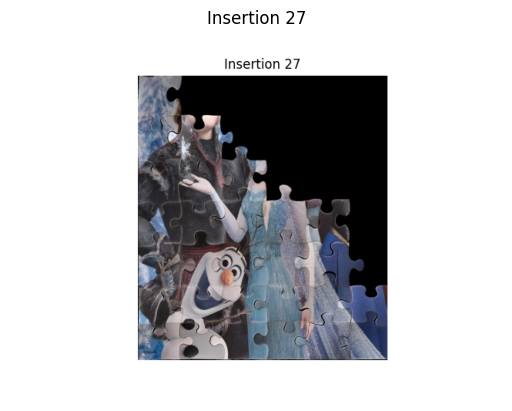

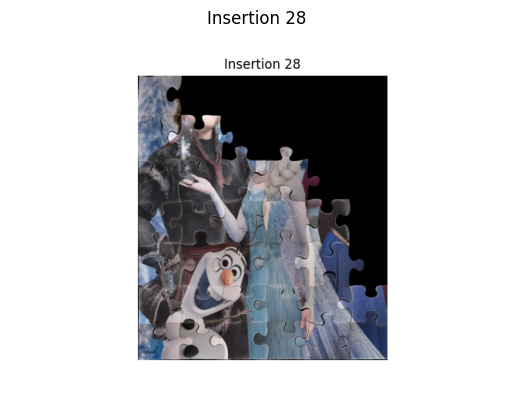

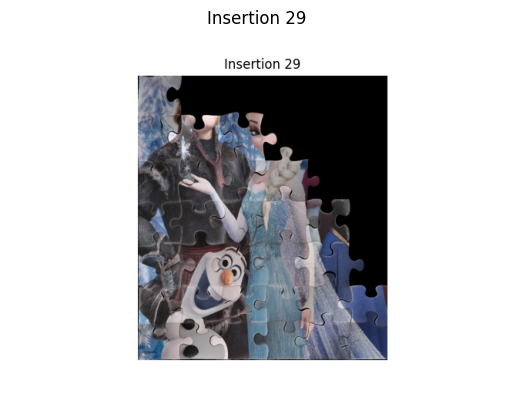

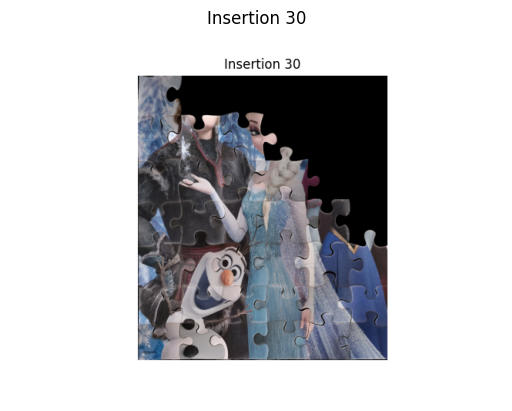

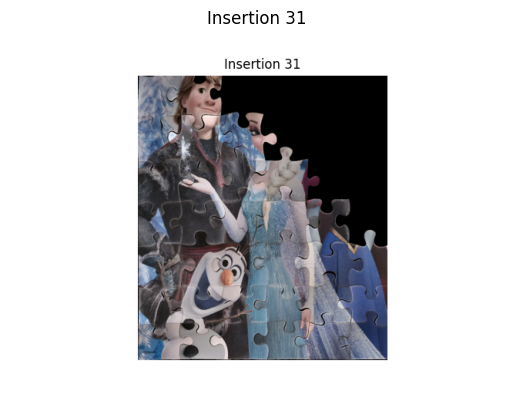

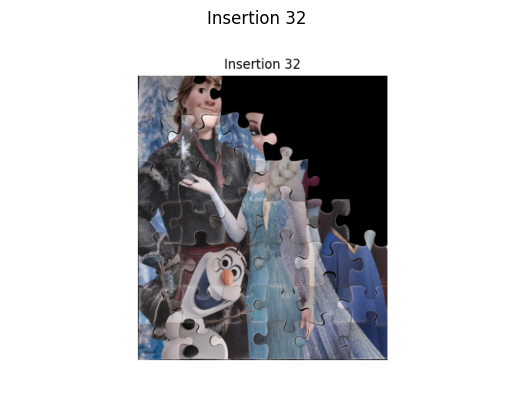

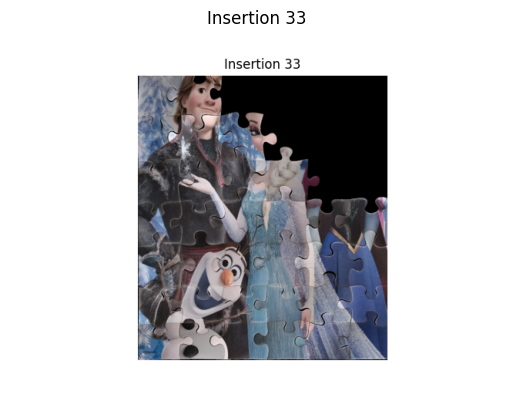

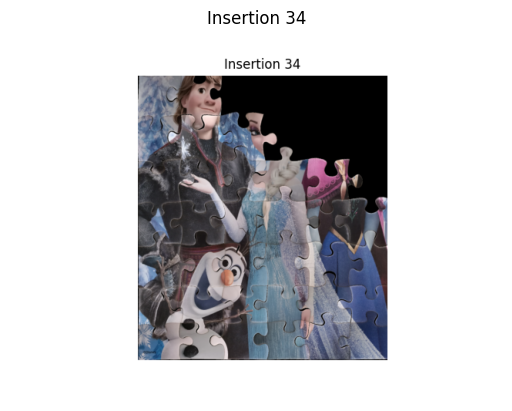

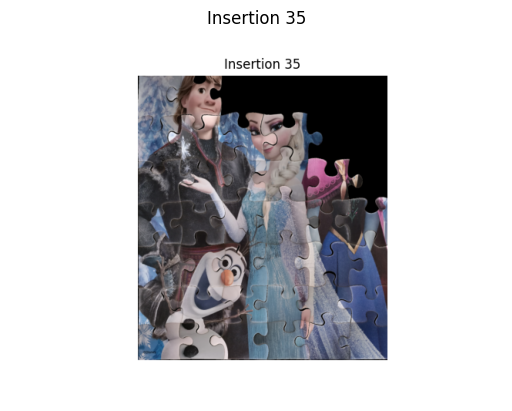

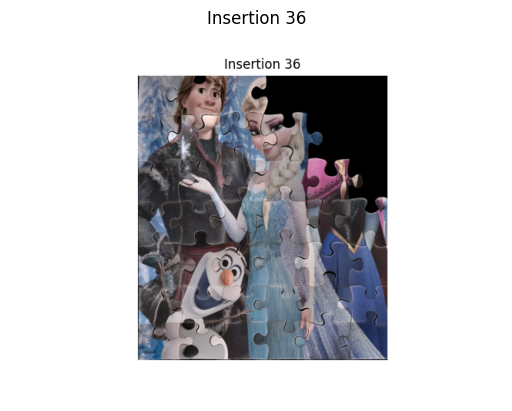

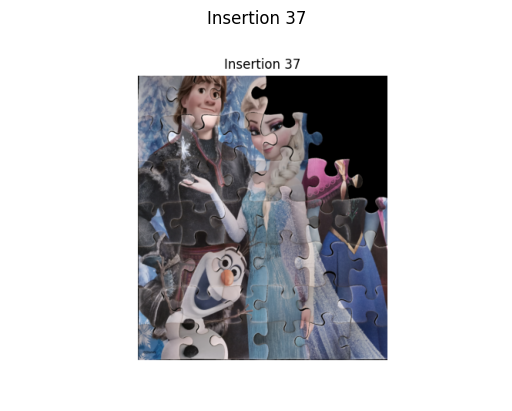

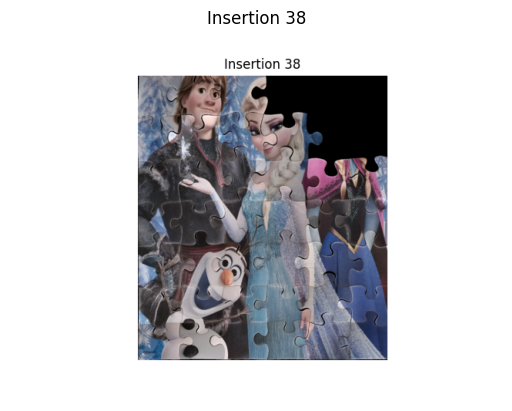

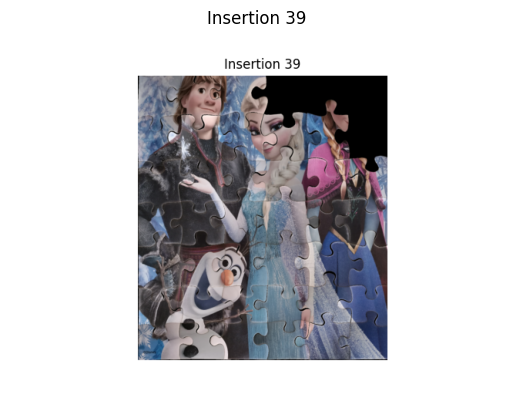

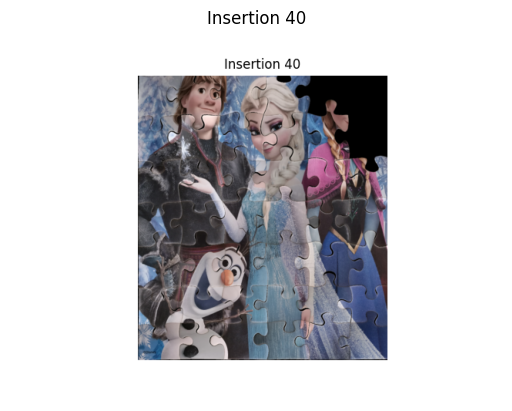

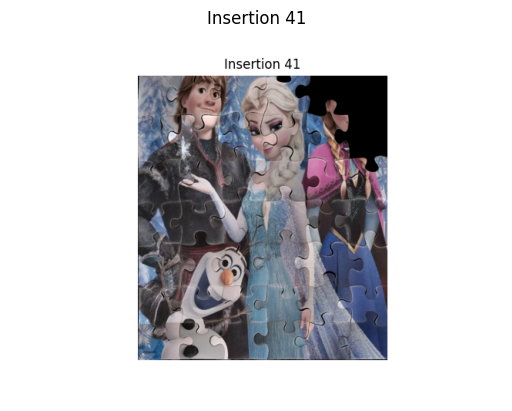

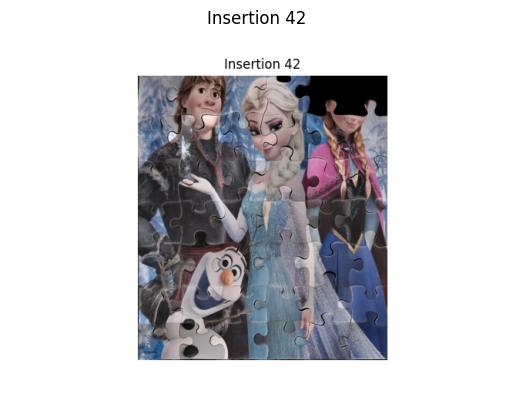

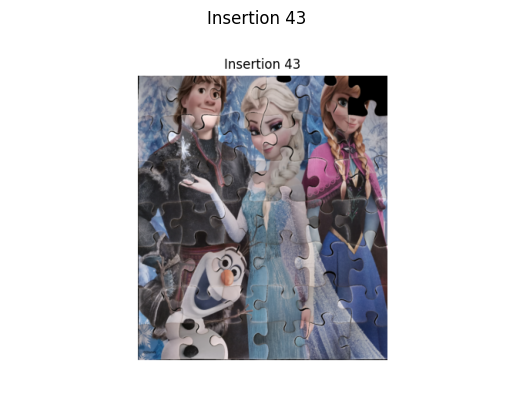

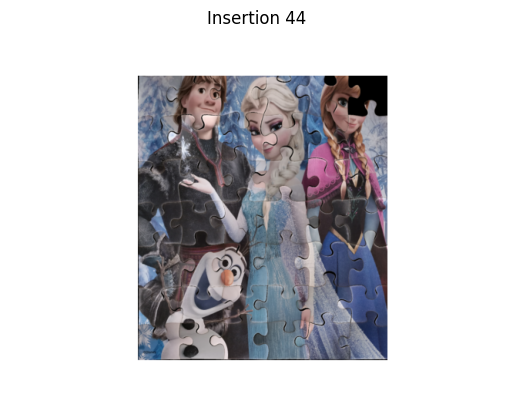

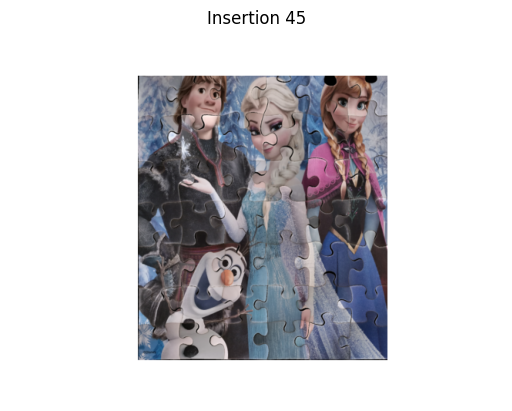

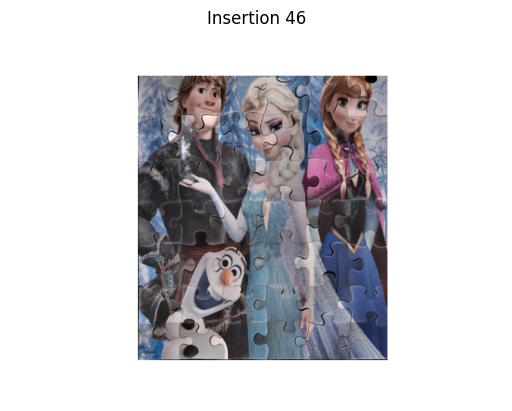

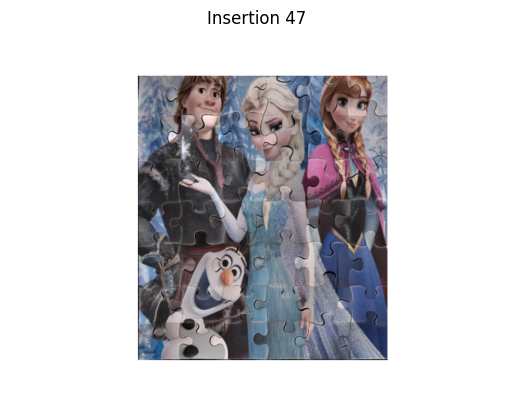

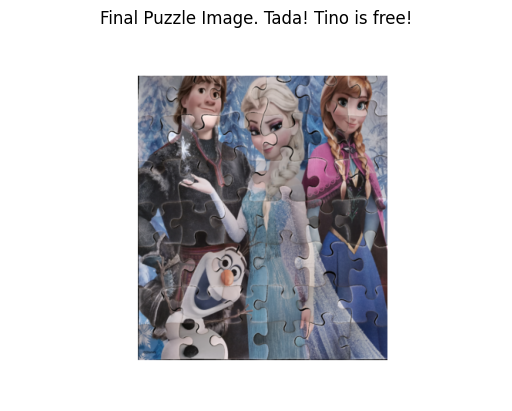

In [ ]:
################################################ Question 6 #############################################

# Initialize the puzzle and select the starting corner piece
puzzle = Puzzle(MATCH_IMGS)
corner_piece = puzzle.pieces[3]

# Start BFS by adding the bottom left corner piece
queue = []
queue.append(corner_piece)
corner_piece.insert()
corner_piece.inserted = True

# List to store images after insertions
insertion_images = []

# BFS to assemble the puzzle
insertions = 0  # Track the number of insertions

while queue:  # Continue until we reach 10 insertions
    current_piece = queue.pop(0)  # Get the current piece from the queue

    # Loop through all edges of the current piece
    for edge in current_piece.edge_list:
        # Check if connected_edge is not None before accessing its attributes
        if edge is not None and edge.connected_edge is not None and not edge.connected_edge.parent_piece.inserted:
            next_piece = edge.connected_edge.parent_piece
            next_piece.insert()
            next_piece.inserted = True
            queue.append(next_piece)
            insertions += 1

            # Capture images after the first 5 insertions
            if insertions <= 5 or insertions > (len(puzzle.pieces) - 5):
                plt.imshow(canvas)
                plt.axis('off')
                plt.savefig(f'insertion_{insertions}.png')  # Save the image
                plt.close()  # Close the figure to avoid displaying it in interactive mode

# After BFS completes, display the final canvas
plt.imshow(canvas)
plt.axis('off')
plt.savefig('final_puzzle.png')
plt.close()

# Load and display all images captured
for i in range(1, insertions + 1):
    img = plt.imread(f'insertion_{i}.png')
    plt.imshow(img)
    plt.title(f'Insertion {i}')
    plt.axis('off')
    plt.show()

# Show the final puzzle image
final_img = plt.imread('final_puzzle.png')
plt.imshow(final_img)
plt.title('Final Puzzle Image. Tada! Tino is free!')
plt.axis('off')
plt.show()